In [2]:
import pymc as pm
import numpy as np
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

1) Estamos interesados en la proporción de éxito 𝜃 de una distribución Bernoulli. Tenemos una
muestra observada que consiste en el número de éxitos en 30 ensayos independientes y con idéntica distribución de una Bernoulli con parámetro 𝜃; en esta muestra hay precisamente 19 éxitos.

(a) Suponiendo una prior uniforme sobre 𝜃, calcular la distribución posterior y graficarla. ¿Cuál
es el 90% HPDI?

(b) Calcular para cada 𝑘 la probabilidad de obtener 𝑘 éxitos en 10 experimentos con la posterior predictive. ¿Se trata ésta de una distribución binomial?

In [3]:
observed_sample = np.array([0] * (30 - 19) + [1] * 19)

with pm.Model() as model1a:
    # prior
    theta = pm.Uniform("theta")
    # likelihood
    bernoulli = pm.Bernoulli("bernoulli", p=theta, observed=observed_sample)
    # sample posterior
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

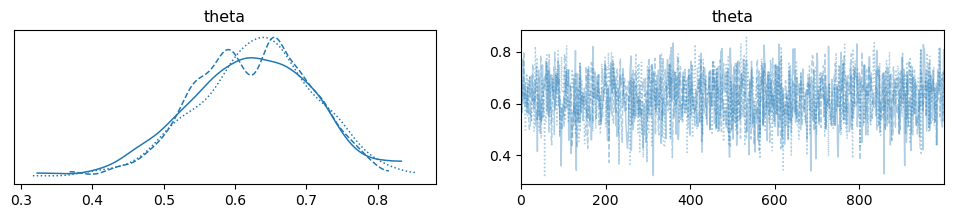

In [4]:
az.plot_trace(trace)

<Axes: title={'center': 'theta'}>

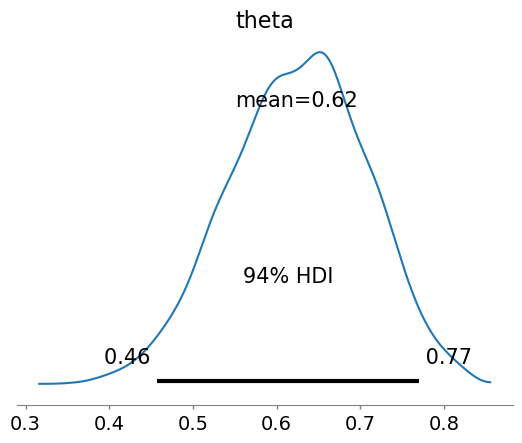

In [5]:
az.plot_posterior(trace)

In [6]:
with model1a:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [bernoulli]


array([[<Axes: title={'center': 'bernoulli'}>,
        <Axes: title={'center': 'bernoulli'}>]], dtype=object)

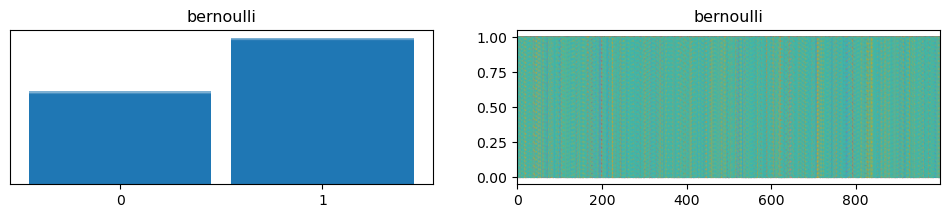

In [7]:
az.plot_trace(trace.posterior_predictive)

In [8]:
sampled_pp = (
    az.extract(trace.posterior_predictive).bernoulli.to_numpy().reshape(10, 9000)
)
binom_distrib = st.binom.pmf(np.arange(0, 11), n=10, p=19 / 30)

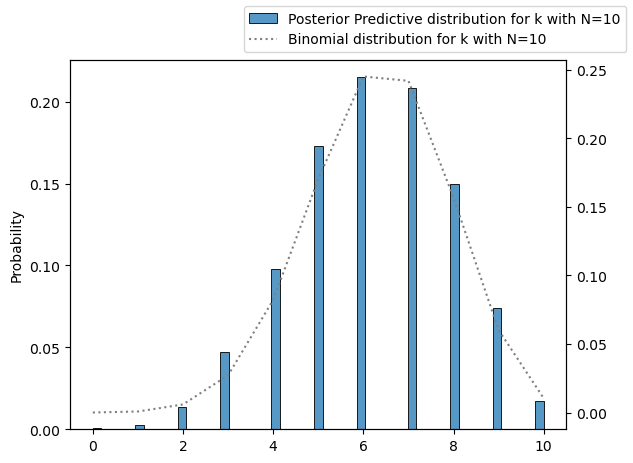

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

sns.histplot(
    sampled_pp.sum(axis=0),
    label="Posterior Predictive distribution for k with N=10",
    stat="probability",
    ax=ax1,
)
sns.lineplot(
    x=np.arange(0, 11),
    y=binom_distrib,
    label="Binomial distribution for k with N=10",
    ax=ax2,
    color="gray",
    linestyle="dotted",
)
ax2.get_legend().remove()
fig.legend()

In [10]:
observed_sample = np.array([0] * (30 - 19) + [1] * 19)

with pm.Model() as model2:
    # prior
    w = np.array([0.0001, 0.9999])
    uniform1 = pm.Uniform.dist(0, 0.5)
    uniform2 = pm.Uniform.dist(0.5, 1)

    theta = pm.Mixture("theta", w=w, comp_dists=[uniform1, uniform2])

    prior = pm.sample_prior_predictive(10000)

c:\Users\Damm\anaconda3\Lib\site-packages\pymc\distributions\mixture.py:479: MixtureTransformWarning: No safe default transform found for Mixture distribution theta. This can happen when components have different supports or default transforms.
If appropriate, you can specify a custom transform for more efficient sampling.
  transform_warning()
Sampling: [theta]


<Axes: >

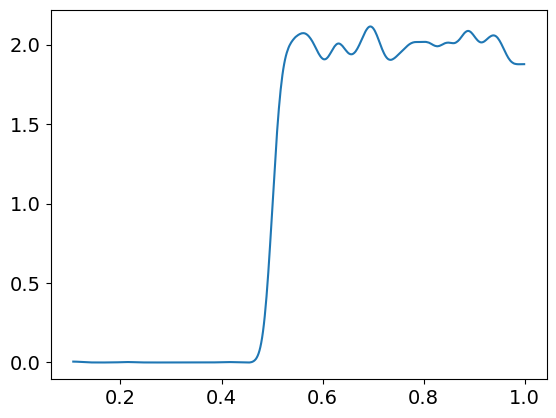

In [11]:
az.plot_dist(prior.prior.to_array())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

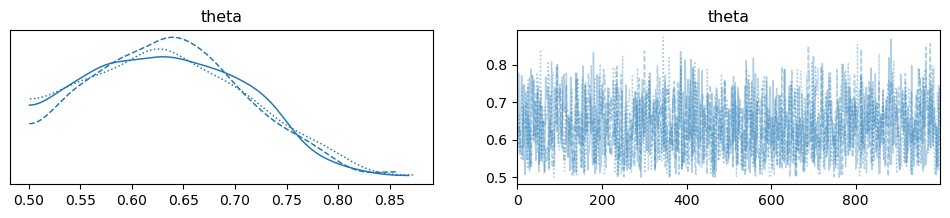

In [12]:
with model2:
    # likelihood
    bernoulli = pm.Bernoulli("bernoulli", p=theta, observed=observed_sample)
    # sample posterior
    trace = pm.sample()

az.plot_trace(trace)

<Axes: title={'center': 'theta'}>

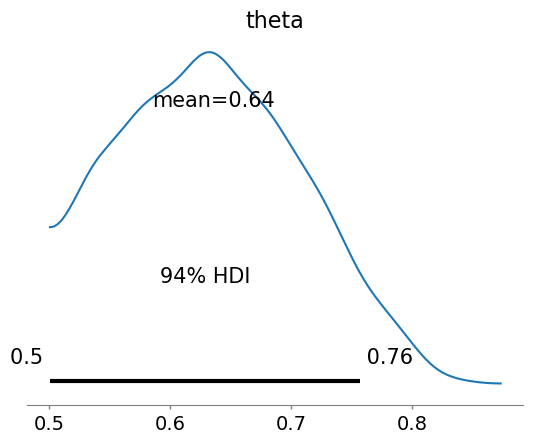

In [13]:
az.plot_posterior(trace)

Sampling: [bernoulli]


array([[<Axes: title={'center': 'bernoulli'}>,
        <Axes: title={'center': 'bernoulli'}>]], dtype=object)

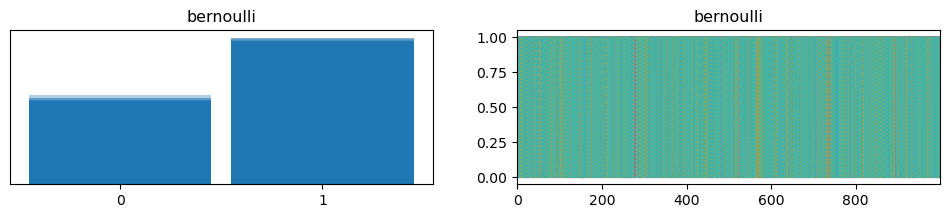

In [14]:
with model2:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
az.plot_trace(trace.posterior_predictive)

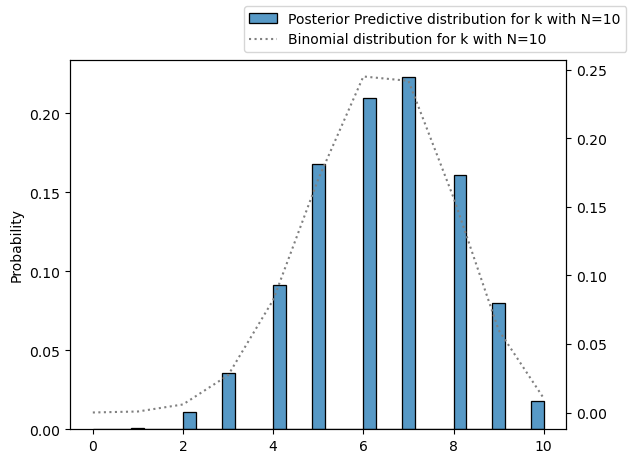

In [15]:
sampled_pp = (
    az.extract(trace.posterior_predictive).bernoulli.to_numpy().reshape(10, 9000)
)
binom_distrib = st.binom.pmf(np.arange(0, 11), n=10, p=19 / 30)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

sns.histplot(
    sampled_pp.sum(axis=0),
    label="Posterior Predictive distribution for k with N=10",
    stat="probability",
    ax=ax1,
)
sns.lineplot(
    x=np.arange(0, 11),
    y=binom_distrib,
    label="Binomial distribution for k with N=10",
    ax=ax2,
    color="gray",
    linestyle="dotted",
)
ax2.get_legend().remove()
fig.legend()

3) Una muestra de estudiantes es medida en altura cada año durante 3 años. Después del tercer
año, se quiere ajustar una regresión lineal bayesiana para predecir la altura usando el año como
predictor. Escribe la definición matemática para esta regresión, justificando la elección de priors.

(a) Supongamos que cada estudiante creció cada año. ¿Es necesario cambiar la elección de
priors?

(b) Supongamos que la varianza entre las alturas de los estudiantes de la misma edad nunca es
más de 64 cm. ¿Lleva esto a revisar los priors?


In [16]:
N = 50  # numero de alumnos
X = np.random.randint(1, 3, N)
e = np.random.normal(0, 1, N)

Y = 2 * X + 145 + e


with pm.Model() as model3:  # priors no informativos
    variance = pm.InverseGamma(
        "variance", alpha=0.5, beta=0.5
    )  # error variance, HalfCauchy for std.
    slope = pm.Normal("slope", mu=0, sigma=10)  # slope
    intercept = pm.Normal("intercept", mu=0, sigma=10)  # intercept

    # linear model
    mu = slope * X + intercept

    # likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=variance**0.5, observed=Y)

In [17]:
with model3:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [variance, slope, intercept]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


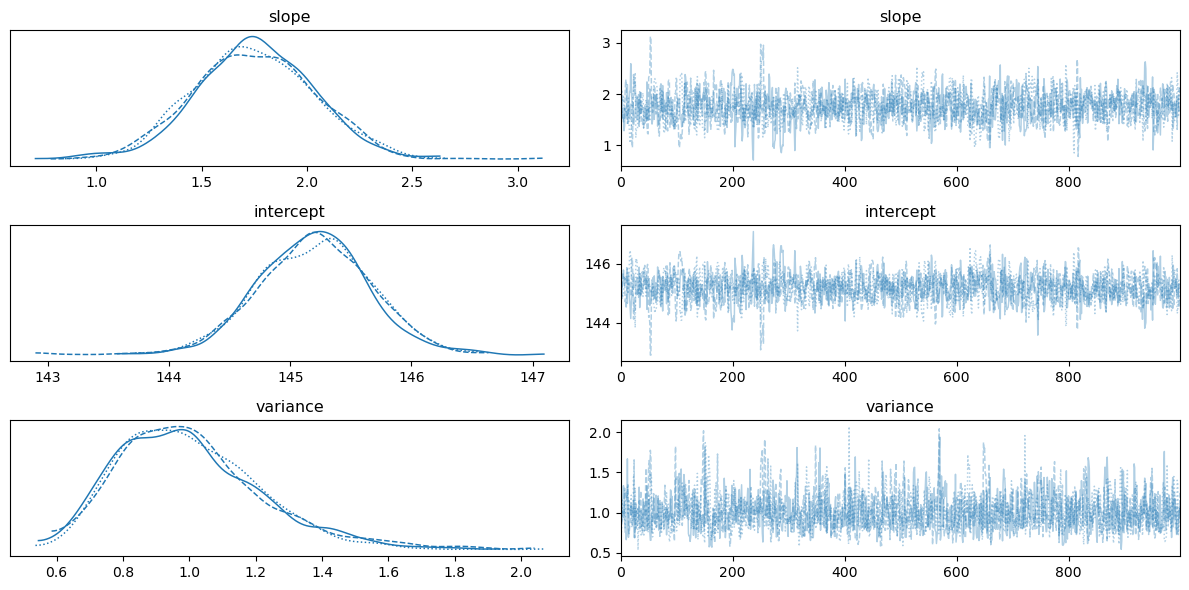

In [18]:
az.plot_trace(trace)
plt.tight_layout()

In [19]:
# supongo que tengo datos historicos o experiencia previa que me permiten tener una idea de los valores de los parametros

# pendiente positiva
intercept_mean = Y[X == 1].mean()  # intercept promedio de los datos con X = 1

with pm.Model() as model3b:  # priors informativos
    variance = pm.InverseGamma(
        "variance", alpha=0.5, beta=0.5
    )  # error variance, HalfCauchy for std.
    slope = pm.HalfNormal("slope", sigma=10)  # slope positiva.
    intercept = pm.Normal("intercept", mu=intercept_mean, sigma=10)  # intercept

    # linear model
    mu = slope * X + intercept

    # likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Yobs", mu=mu, sigma=variance**0.5, observed=Y)
model3b

 variance ~ InverseGamma(0.5, 0.5)
    slope ~ HalfNormal(0, 10)
intercept ~ Normal(147, 10)
     Yobs ~ Normal(f(intercept, slope), f(variance))

In [20]:
with model3b:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [variance, slope, intercept]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


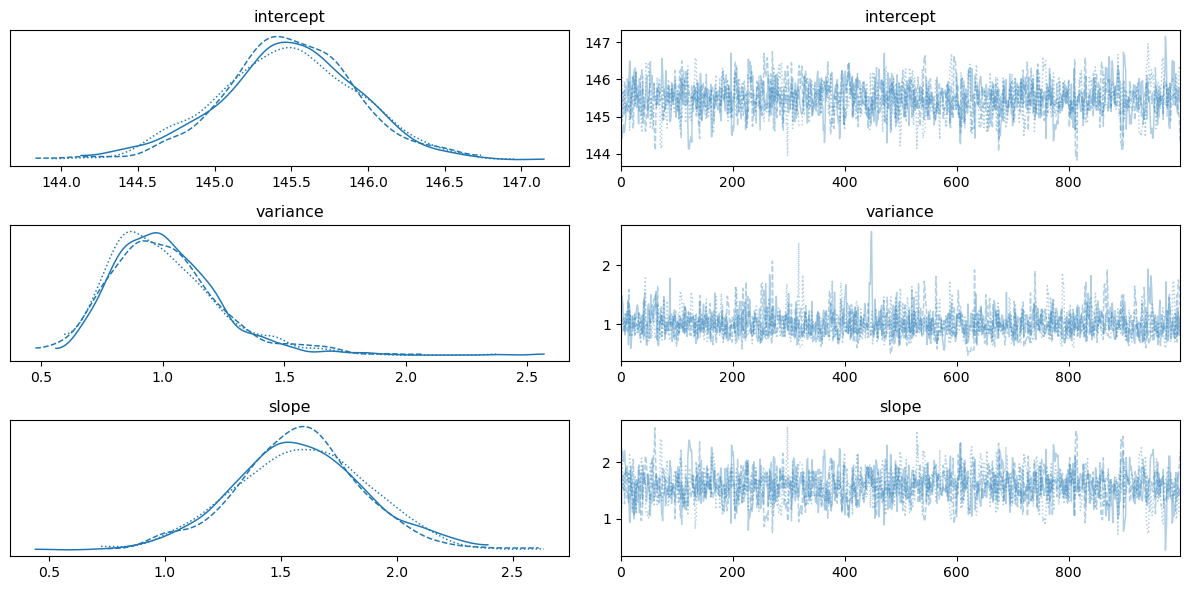

In [21]:
az.plot_trace(trace)
plt.tight_layout()

4) Generar datos de una regresión lineal simple con ruido gaussiano.

(a) Ajustar un modelo lineal con PyMC con ruido gaussiano. Graficar y describir las posterior
de los parámetros de la regresión.

(b) Generar datos para una regresión lineal con ruido skew-normal, como en el parcial 1. Ajustar
un modelo lineal con PyMC con ruido gaussiano. Graficar y describir las posterior de los
parámetros de la regresión.

In [22]:
N = 50
X = np.random.uniform(0, 10, N)
e = np.random.normal(0, 1, N)

Y = X + 5 + e


with pm.Model() as model4a:  # priors no informativos
    variance = pm.InverseGamma(
        "variance", alpha=0.5, beta=0.5
    )  # error variance, HalfCauchy for std.
    slope = pm.Normal("slope", mu=0, sigma=10**2)  # slope
    intercept = pm.Normal("intercept", mu=0, sigma=10**2)  # intercept

    # linear model
    mu = slope * X + intercept

    # likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Yobs", mu=mu, sigma=variance**0.5, observed=Y)
model4a

 variance ~ InverseGamma(0.5, 0.5)
    slope ~ Normal(0, 100)
intercept ~ Normal(0, 100)
     Yobs ~ Normal(f(intercept, slope), f(variance))

In [23]:
with model4a:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [variance, slope, intercept]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


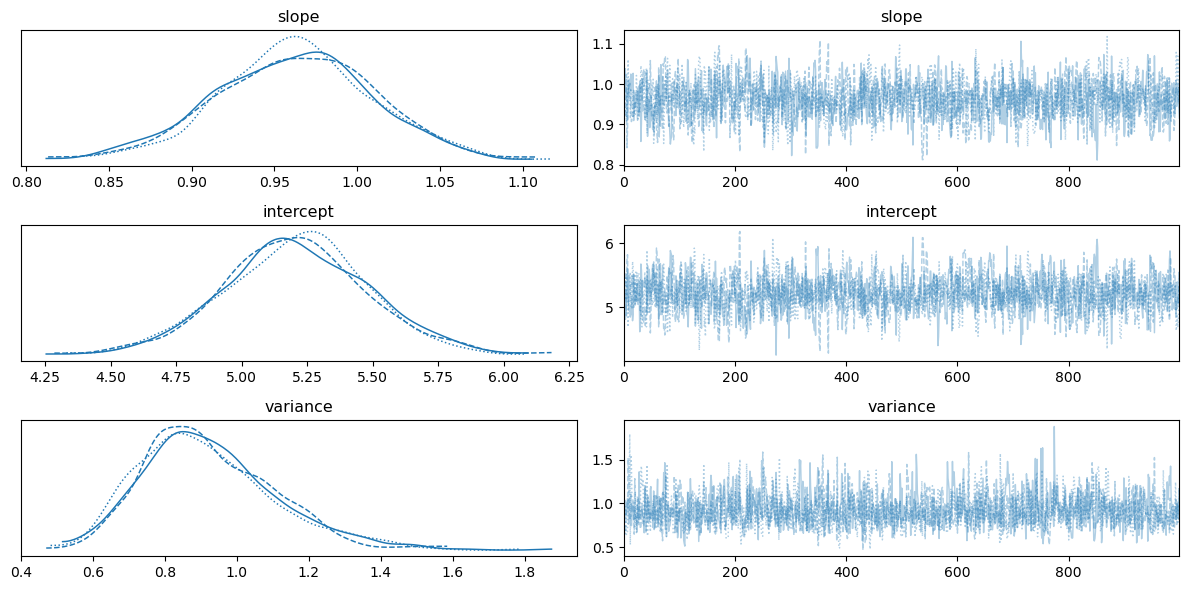

In [24]:
az.plot_trace(trace)
plt.tight_layout()

<Axes: >

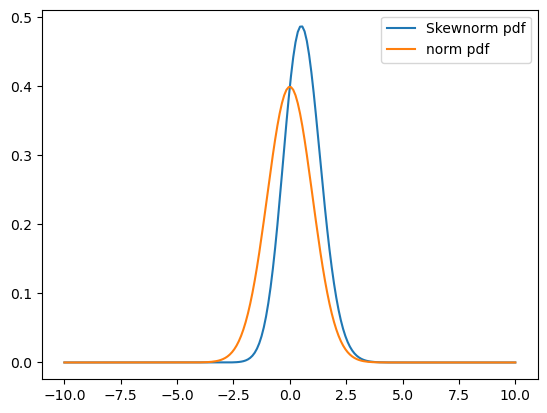

In [25]:
skew_param = 1

sns.lineplot(
    x=np.linspace(-10, 10, 200),
    y=st.skewnorm(a=skew_param, loc=0, scale=1).pdf(np.linspace(-10, 10, 200)),
    label="Skewnorm pdf",
)

sns.lineplot(
    x=np.linspace(-10, 10, 200),
    y=st.norm(loc=0, scale=1).pdf(np.linspace(-10, 10, 200)),
    label="norm pdf",
)

In [26]:
N = 50
X = np.random.uniform(0, 10, N)
# e = np.random.normal(0, 1, N)
e = st.skewnorm(a=skew_param, loc=0, scale=1).rvs(N)

Y = X + 5 + e


with pm.Model() as model4b:  # priors no informativos
    variance = pm.InverseGamma(
        "variance", alpha=0.5, beta=0.5
    )  # error variance, HalfCauchy for std.
    slope = pm.Normal("slope", mu=0, sigma=10**2)  # slope
    intercept = pm.Normal("intercept", mu=0, sigma=10**2)  # intercept

    # linear model
    mu = slope * X + intercept

    # likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Yobs", mu=mu, sigma=variance**0.5, observed=Y)
model4a

 variance ~ InverseGamma(0.5, 0.5)
    slope ~ Normal(0, 100)
intercept ~ Normal(0, 100)
     Yobs ~ Normal(f(intercept, slope), f(variance))

In [27]:
with model4b:
    trace_skew = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [variance, slope, intercept]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


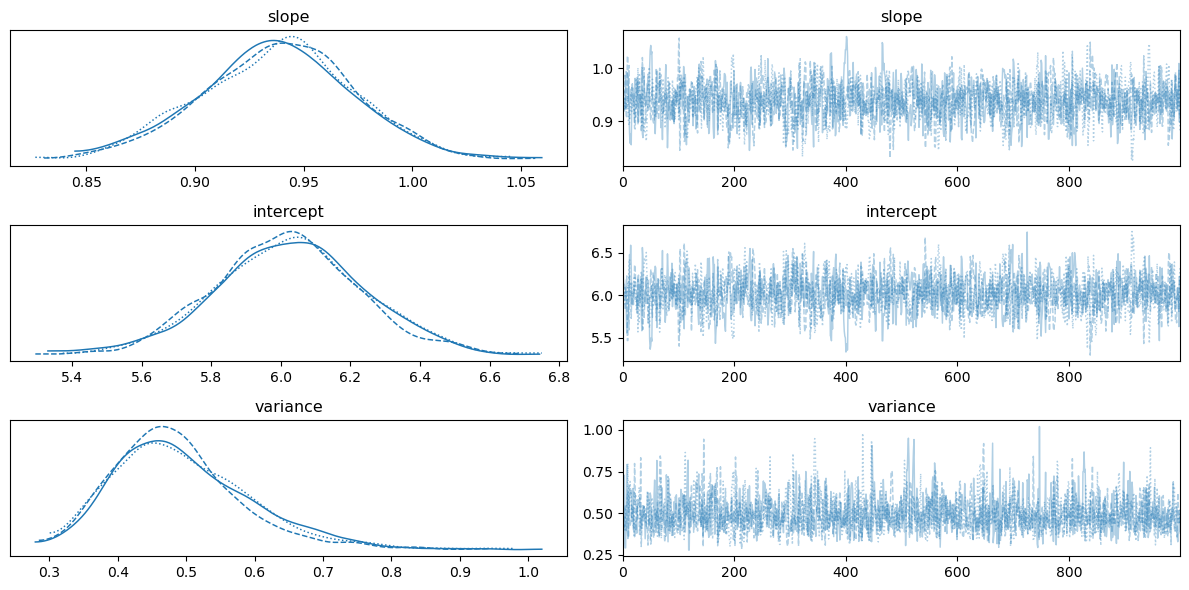

In [28]:
az.plot_trace(trace_skew)
plt.tight_layout()

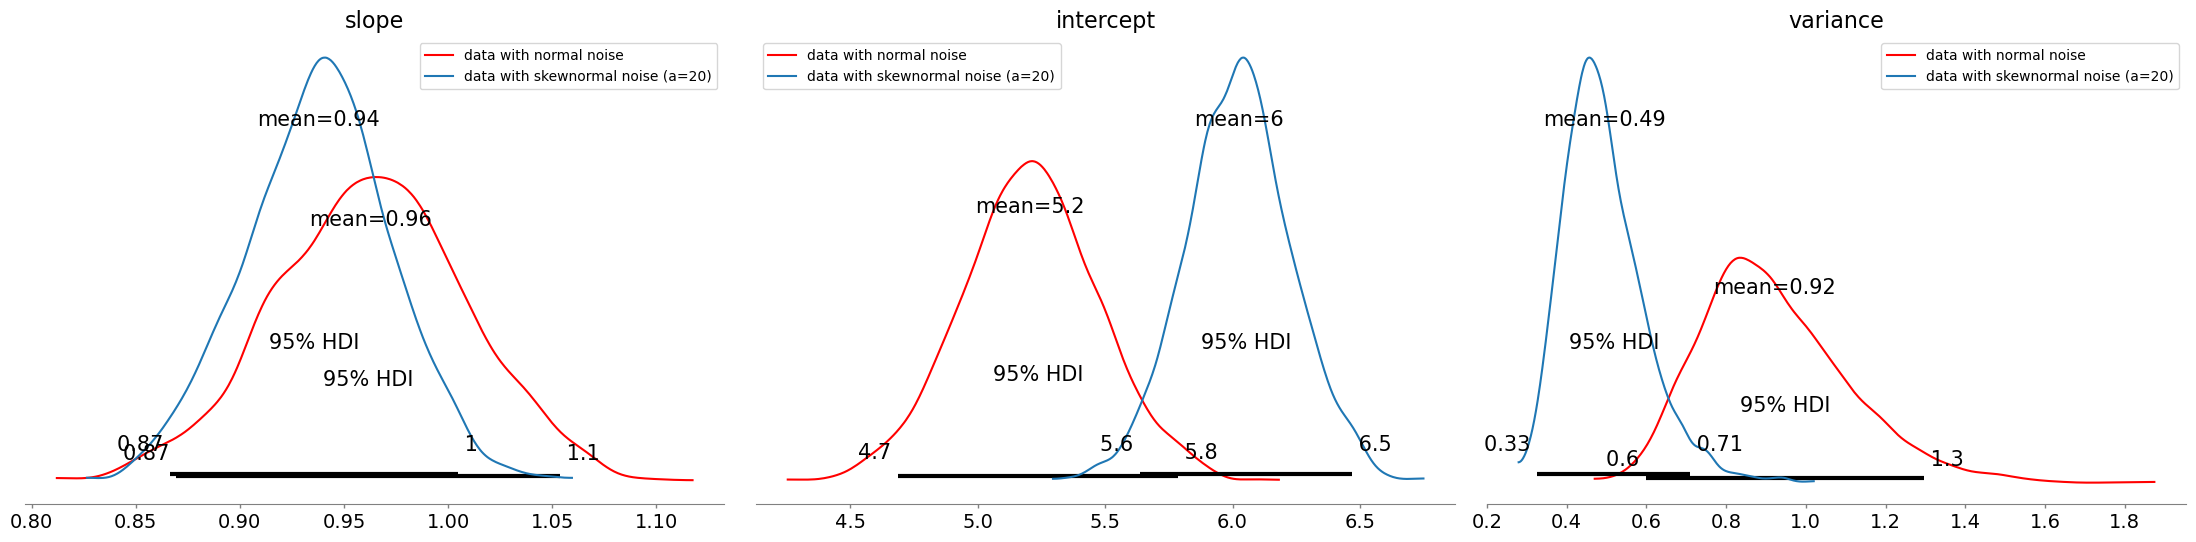

In [29]:
ax = az.plot_posterior(
    trace, label="data with normal noise", color="red", hdi_prob=0.95
)
az.plot_posterior(
    trace_skew, ax=ax, label="data with skewnormal noise (a=20)", hdi_prob=0.95
)
plt.tight_layout()

### Ej4 bis (lo sacaron al otro)

In [30]:
n = 100
X = np.random.uniform(0, 1, n)
e = np.random.normal(0, 0.1, n)
Y = 2 * X - 1 + e

In [31]:
with pm.Model() as gamma_glm:
    # No tengo informacion previa -> priors no informativos.
    beta0 = pm.Normal("beta0", mu=0, sigma=10**2)
    beta1 = pm.Normal("beta1", mu=0, sigma=10**2)
    sigma = pm.HalfCauchy("sigma", beta=1)

    mu = beta0 + beta1 * X

    Yobs = pm.Normal("Yobs", mu=mu, sigma=sigma, observed=Y)
gamma_glm

beta0 ~ Normal(0, 100)
beta1 ~ Normal(0, 100)
sigma ~ HalfCauchy(0, 1)
 Yobs ~ Normal(f(beta0, beta1), sigma)

In [32]:
with gamma_glm:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta0, beta1, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

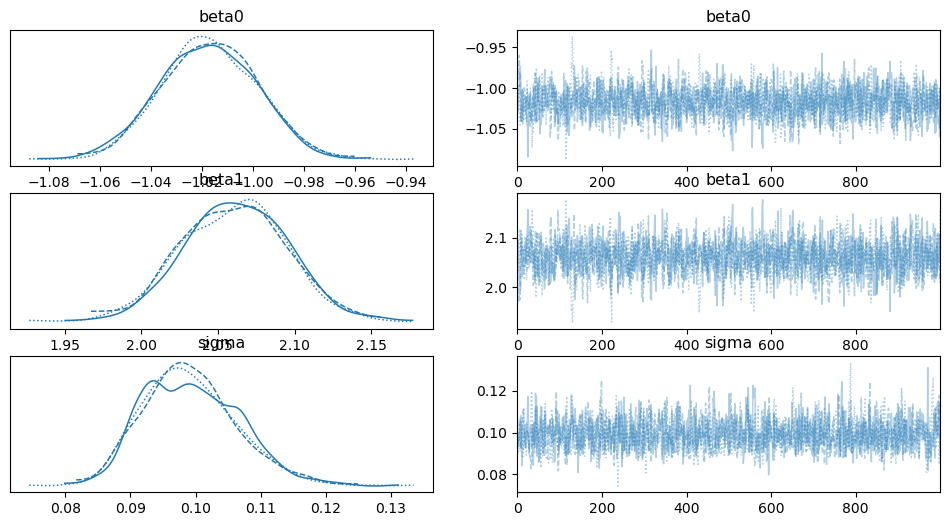

In [33]:
az.plot_trace(trace)

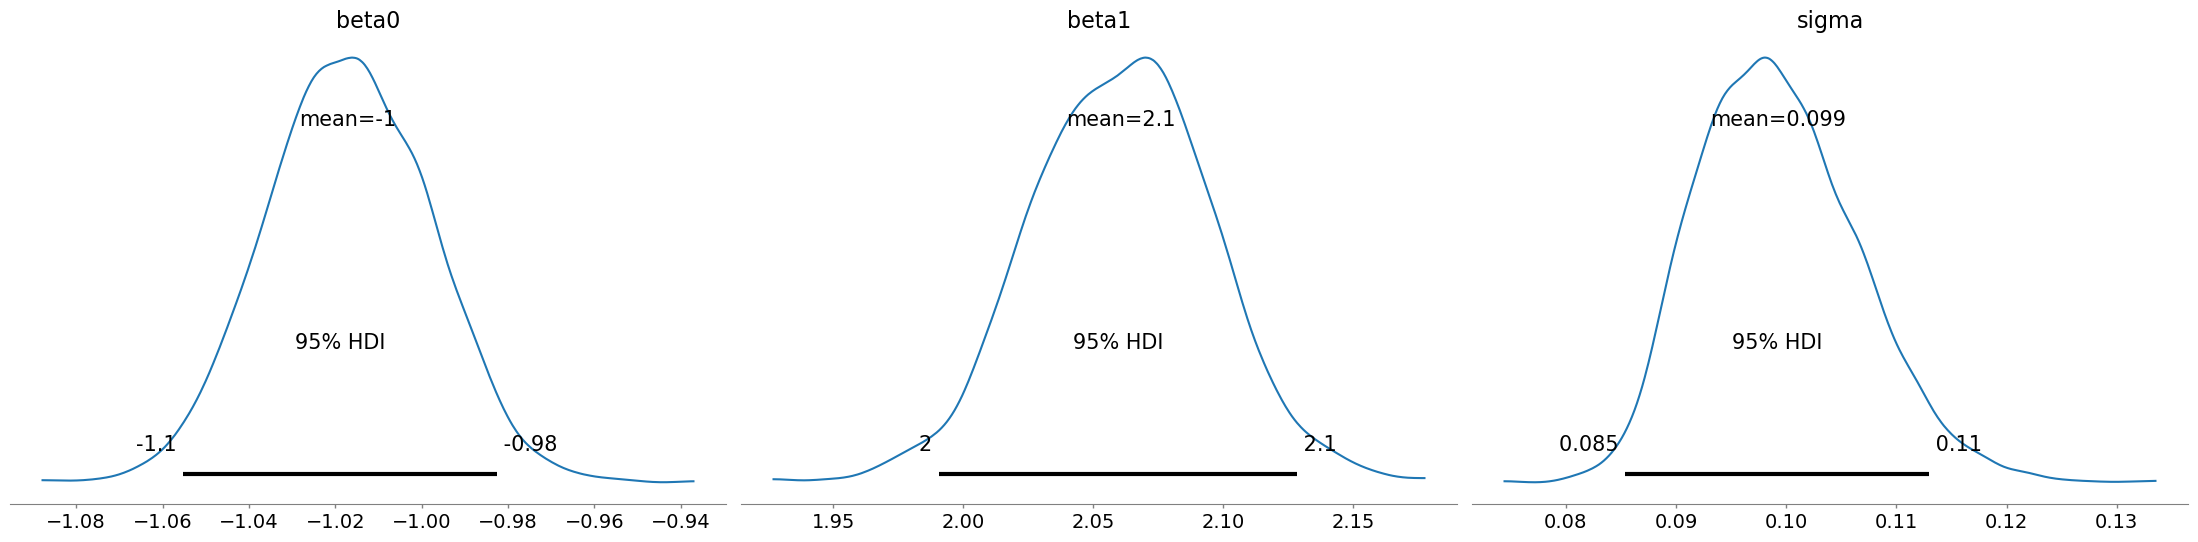

In [34]:
az.plot_posterior(trace, hdi_prob=0.95)
plt.tight_layout()

('percentiles [-0.00598571  0.03328699]',
 'intervalo de confianza [-0.01959964  0.01959964]')

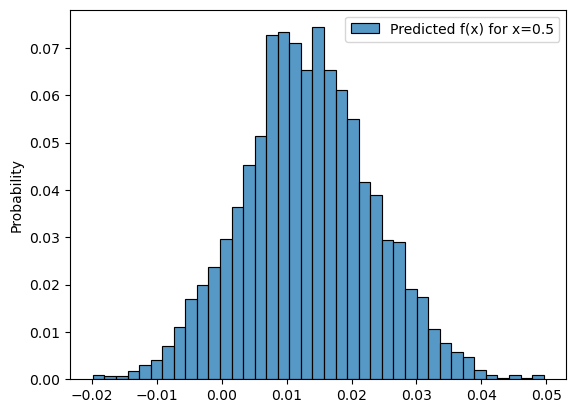

In [35]:
# Valor para X=0.5
B0 = az.extract(trace, var_names=["beta0"], combined=True)
B1 = az.extract(trace, var_names=["beta1"], combined=True)

Y_pred = B0 + B1 * 0.5

# B)
# por la definicion del problema, como mu = f(x=0.5) = 0 =>> mu(x=0.5) ~ N(0, sigma/sqrt(n)) =>>  (0 ± 1.96*sigma/sqrt(n)) es el CI de confianza del 95% para f(x=0.5)

sns.histplot(Y_pred, label="Predicted f(x) for x=0.5", stat="probability")
plt.legend()

f"percentiles {np.percentile(Y_pred, [2.5, 97.5])}", f"intervalo de confianza {st.norm(0, 0.1).ppf([0.025, 0.975])/np.sqrt(n)}"

### EJ5

. Particionar el intervalo [0, 1] en 100 intervalos de igual longitud. Considerar una matriz con
100 filas y 1000 columnas que en su fila enésima tiene los resultados de mil experimentos Bernoulli
con probabilidad que está en el intervalo enésimo.

(a) Obtener un vector de largo 100 tomando la media de la matriz a lo largo del eje correspondiente y plotear ese vector contra el vector dado por los puntos medios de los intervalos en los que se particionó el [0, 1].

(b) Utilizar el paquete arviz para plotear el 90% HDI de cada fila como una sombra sobre el
gráfico anterior

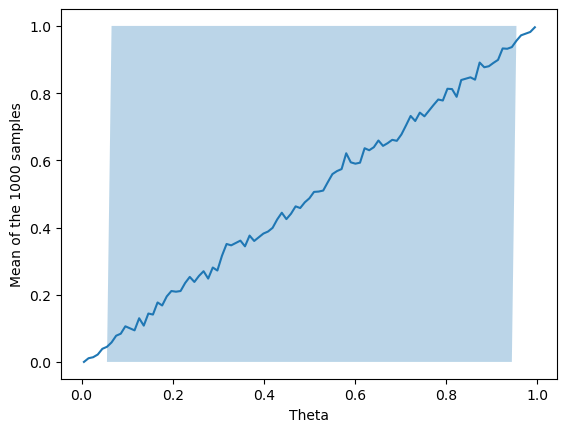

In [36]:
theta_interval = np.linspace(0, 1, 100)

matrix = np.empty(shape=(100, 1000))

for i, theta in enumerate(theta_interval):
    matrix[i] = np.random.binomial(n=1, p=theta, size=1000)

mean_by_theta = matrix.mean(axis=1)[:-1]  ## mid_points solo tiene 99. saco un punto
mid_points = (theta_interval[1:] + theta_interval[:-1]) / 2

plt.plot(mid_points, mean_by_theta, label="Mean of the samples")
plt.xlabel("Theta")
plt.ylabel("Mean of the 1000 samples")

hdi_array = np.empty(shape=(100, 2))

for i, row in enumerate(matrix):
    hdi_array[i] = az.hdi(row, hdi_prob=0.95)
hdi_array = hdi_array[:-1]

plt.fill_between(mid_points, hdi_array[:, 0], hdi_array[:, 1], alpha=0.3, label="HDI")

6. En el ajuste lineal del problema 4 graficar los datos sintéticos generados, el 90% HDI de 𝛽0 +𝛽1𝑥
para cada valor de 𝑥, y el el 90% HDI para las estimaciones de 𝑦.

In [37]:
n = 100
X = np.random.uniform(0, 1, n)
e = np.random.normal(0, 0.05, n)
Y = 2 * X - 1 + e

In [38]:
with pm.Model() as linearmodel:
    # No tengo informacion previa -> priors no informativos.
    beta0 = pm.Normal("beta0", mu=0, sigma=10**2)
    beta1 = pm.Normal("beta1", mu=0, sigma=10**2)
    sigma = pm.HalfCauchy("sigma", beta=1)

    mu = beta0 + beta1 * X

    Yobs = pm.Normal("Yobs", mu=mu, sigma=sigma, observed=Y)
linearmodel

beta0 ~ Normal(0, 100)
beta1 ~ Normal(0, 100)
sigma ~ HalfCauchy(0, 1)
 Yobs ~ Normal(f(beta0, beta1), sigma)

In [39]:
with linearmodel:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta0, beta1, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


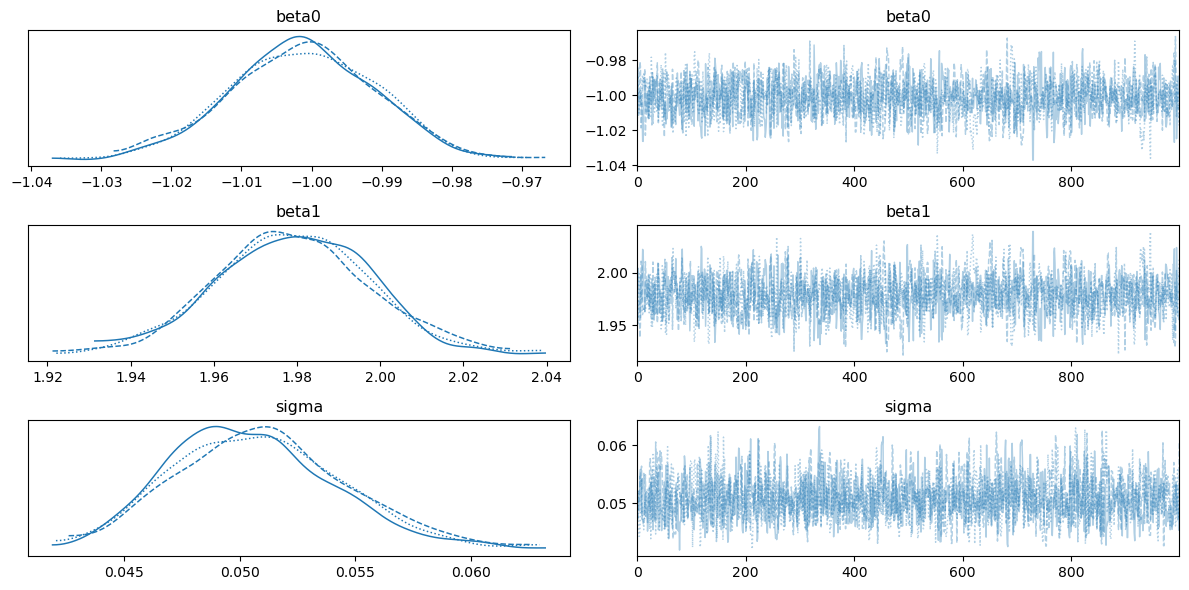

In [40]:
az.plot_trace(trace)
plt.tight_layout()

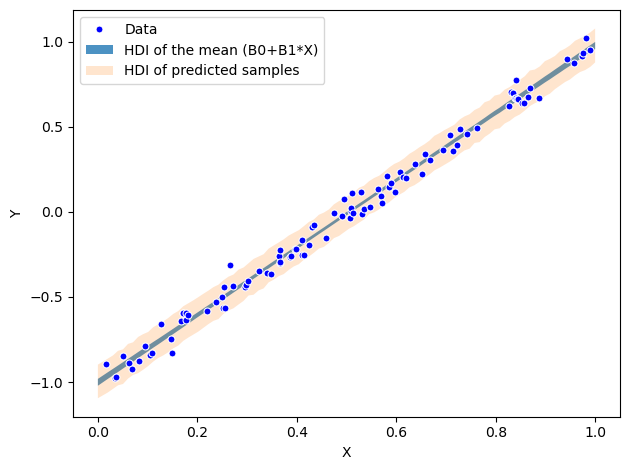

In [41]:
sns.lineplot(
    x=X, y=Y, label="Data", color="blue", marker="o", linestyle="None", markersize=5
)

trace_data = az.extract(trace, var_names=["beta0", "beta1", "sigma"], combined=True)

beta0_trace = trace_data["beta0"].to_numpy()
beta1_trace = trace_data["beta1"].to_numpy()
sigma_trace = trace_data["sigma"].to_numpy()


mu_hdi = np.empty(shape=(n, 2))

mean_trace = []
hdi_of_mean_trace = []
for x in np.linspace(0, 1, 100):
    mean_trace.append(beta0_trace + beta1_trace * x)
    hdi_of_mean_trace.append(az.hdi(beta0_trace + beta1_trace * x, hdi_prob=0.95))

mean_trace = np.array(mean_trace)
hdi_of_mean_trace = np.array(hdi_of_mean_trace)

plt.fill_between(
    np.linspace(0, 1, 100),
    hdi_of_mean_trace[:, 0],
    hdi_of_mean_trace[:, 1],
    alpha=0.8,
    label="HDI of the mean (B0+B1*X)",
)


y_sample_trace = []
hdi_of_y_sample_trace = []

for x in np.linspace(0, 1, 100):
    y_sample_from_trace = st.norm.rvs(
        loc=beta0_trace + beta1_trace * x, scale=sigma_trace
    )
    y_sample_trace.append(y_sample_from_trace)

    hdi_of_y_sample_trace.append(az.hdi(y_sample_from_trace, hdi_prob=0.95))

y_sample_trace = np.array(y_sample_trace)
hdi_of_y_sample_trace = np.array(hdi_of_y_sample_trace)

plt.fill_between(
    np.linspace(0, 1, 100),
    hdi_of_y_sample_trace[:, 0],
    hdi_of_y_sample_trace[:, 1],
    alpha=0.2,
    label="HDI of predicted samples",
)

plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()

7. Realizar un ajuste usando PyMC de un GLM de la práctica 3. Graficar la posterior de los parámetros. Graficar los datos y el HDI de la posterior predictive.


In [42]:
import pandas as pd

data = pd.read_csv(
    "https://raw.githubusercontent.com/franciscokordon/estainferencia/main/data/nambeware.csv",
    index_col=0,
)
data.head()

,Type,Diam,Time,Price
0,CassDish,10.7,47.65,144.0
1,CassDish,14.0,63.13,215.0
2,CassDish,9.0,58.76,105.0
3,Bowl,8.0,34.88,69.0
4,Dish,10.0,55.53,134.0


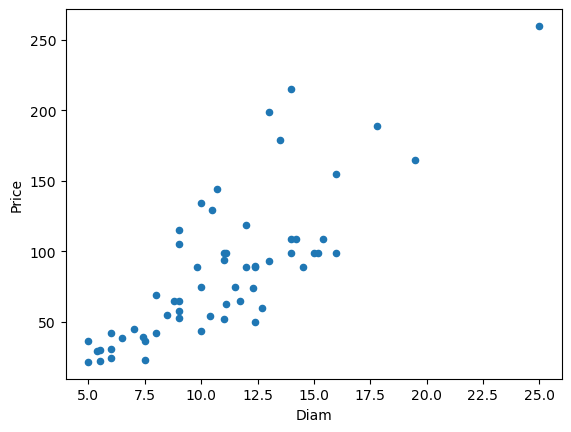

In [43]:
data.plot(kind="scatter", y="Price", x="Diam")

# Varianza aumenta con el valor del diametro, aproximadamente cuadraticamente. Propongo un gamma que tiene funcion varianza cuadratica.
X = data["Diam"]
Y = data["Price"]

In [44]:
with pm.Model() as gamma_glm:
    # No tengo informacion previa -> priors no informativos.
    beta0 = pm.Normal("beta0", mu=0, sigma=10**1)
    beta1 = pm.Normal("beta1", mu=0, sigma=10**1)
    sigma = pm.HalfCauchy("sigma", beta=1)

    mu = np.exp(beta0 + beta1 * X)  # funcion de link ln(mu) = etha.

    Yobs = pm.Gamma("Yobs", mu=mu, sigma=sigma, observed=Y)
gamma_glm

beta0 ~ Normal(0, 10)
beta1 ~ Normal(0, 10)
sigma ~ HalfCauchy(0, 1)
 Yobs ~ Gamma(f(sigma, beta0, beta1), f(sigma, beta0, beta1))

In [45]:
with gamma_glm:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta0, beta1, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


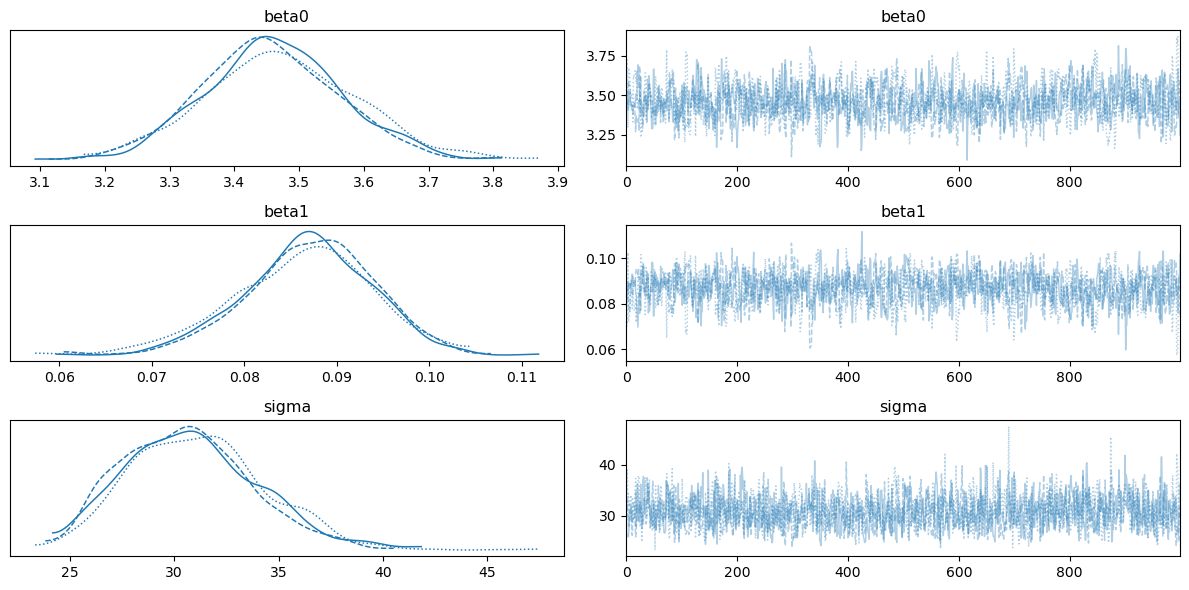

In [46]:
az.plot_trace(trace)
plt.tight_layout()

In [47]:
X_test = np.linspace(X.min(), X.max(), 100)
beta0_trace = trace.posterior.beta0.values.flatten()
beta1_trace = trace.posterior.beta1.values.flatten()
sigma_trace = trace.posterior.sigma.values.flatten()

mu_pred = np.zeros((len(X_test), len(beta1_trace)))
likes_pred = np.zeros((len(X_test), len(beta1_trace)))

for i, x in enumerate(X_test):
    mu_pred[i, :] = np.exp(beta0_trace + beta1_trace * x)
    # likes_pred[i, :] = np.random.gamma(shape=mu_pred[i, :], scale=sigma_trace) # USA OTRA PARAMETRIZACION
    # likes_pred[i, :] = pm.draw(pm.Gamma.dist(mu=mu_pred[i, :], sigma=sigma_trace), draws=1) ## <--- mas facil usar pymc en terminos de la media/std

    alpha = mu_pred[i, :] ** 2 / sigma_trace**2  ##otra opcion convertir a alpha/beta
    beta = mu_pred[i, :] / sigma_trace**2
    likes_pred[i, :] = st.gamma.rvs(a=alpha, scale=1 / beta)

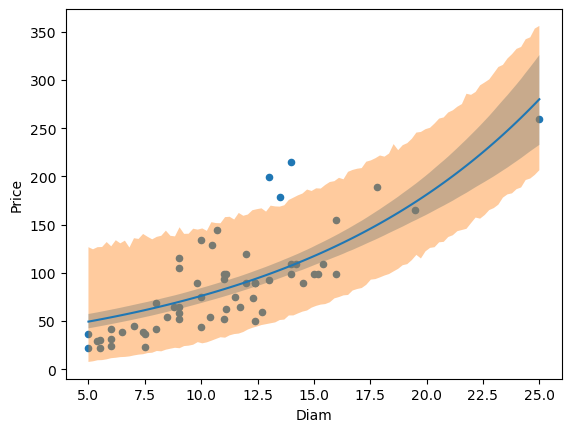

In [48]:
data.plot(kind="scatter", y="Price", x="Diam")
plt.plot(X_test, mu_pred.mean(axis=1))
plt.fill_between(
    X_test,
    np.percentile(mu_pred, 2.5, axis=1),
    np.percentile(mu_pred, 97.5, axis=1),
    alpha=0.4,
)
plt.fill_between(
    X_test,
    np.percentile(likes_pred, 2.5, axis=1),
    np.percentile(likes_pred, 97.5, axis=1),
    alpha=0.4,
)